# Yandex Data Science School
## Linear Regression & Regularization Exercise.
### Written by Dr. Hanan Shteingart.

## Outline
In this exercise you will learn the following topics:

1. Refresher on how linear regression is solved in batch and in Gradient Descent 
2. Implementation of Ridge Regression
3. Comparing Ridge, Lasso and vanila Linear Regression on a dataset

## Refresher on Ordinary Least Square (OLS) aka Linear Regeression

### Lecture Note

In Matrix notration, the matrix $X$ is of dimensions $n \times p$ where is each row is an example and each column is a feature dimension. 

Similarily, $y$ is of dimension $n \times 1$ and $w$ is of dimensions $p \times 1$.

The model is $\hat{y}=X\cdot w$ where we assume for simplicity that $X$'s first columns equals to 1 (one padding), to account for the bias term.

Our objective is to optimize the loss $L$ defines as resiudal sum of squares (RSS): 

$L_{RSS}=\frac{1}{N}\left\Vert Xw-y \right\Vert^2$ (notice that in matrix notation this means summing over all examples, so $L$ is scalar.)

To find the optimal $w$ one needs to derive the loss with respect to $w$.

$\frac{\partial{L_{RSS}}}{\partial{w}}=\frac{2}{N}X^T(Xw-y)$ (to see why, read about [matrix derivatives](http://www.gatsby.ucl.ac.uk/teaching/courses/sntn/sntn-2017/resources/Matrix_derivatives_cribsheet.pdf) or see class notes )

Thus, the gardient descent solution is $w'=w-\eta \frac{2}{N}X^T(Xw-y)$.

Solving $\frac{\partial{L_{RSS}}}{\partial{w}}=0$ for $w$ one can also get analytical solution:

$w_{OLS}=(X^TX)^{-1}X^Ty$

The first term, $(X^TX)^{-1}X^T$ is also called the pseudo inverse of $X$.

See [lecture note from Stanford](https://web.stanford.edu/~mrosenfe/soc_meth_proj3/matrix_OLS_NYU_notes.pdf) for more details.


In [1]:
#Initializations

from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
import torch
from sklearn.preprocessing import StandardScaler


## Exercise 1 - Ordinary Least Square
* Get the boston housing dataset by using the scikit-learn package. hint: [load_boston](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html)

* What is $p$? what is $n$ in the above notation? hint: [shape](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.shape.html)

* write a model `OrdinaryLinearRegression` which has a propoery $w$ and 3 methods: `fit`, `predict` and `score` (which returns the MSE on a given sample set). Hint: use [numpy.linalg.pinv](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.pinv.html) to be more efficient.

* Fit the model. What is the training MSE?

* Plot a scatter plot where on x-axis plot $Y$ and in the y-axis $\hat{Y}_{OLS}$

* Split the data to 75% train and 25% test 20 times. What is the average MSE now for train and test? Hint: use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) or [ShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html).

* Use a t-test to proove that the MSE for training is significantly smaller than for testing. What is the p-value? Hint: use [scipy.stats.ttest_rel](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_rel.html). 

* Write a new class `OrdinaryLinearRegressionGradientDescent` which inherits from `OrdinaryLinearRegression` and solves the problem using gradinet descent. The class should get as a parameter the learning rate and number of iteration. Plot the class convergance. What is the effect of learning rate? How would you find number of iteration automatically? Note: Gradient Descent does not work well when features are not scaled evenly (why?!). Be sure to normalize your features first.

* **Bonus:** Repeat for coordinate descent by creating a new class `OrdinaryLinearRegressionCoordinateDescent` which also inherits from `OrdinaryLinearRegression`. Compare the learning curves.


Our dataset has n: 506 observations with p: 13 features
The training MSE for OLR is:  21.894831181729202
The average MSE for OLR is:  26.38240391201412
Our p-value is:  0.0038686346317861357
Being such a low number, we can reject the null hypothesis of identical average scores.
We stopped at iteration:  200
The training MSE for ORLGD is:  21.966655168537198


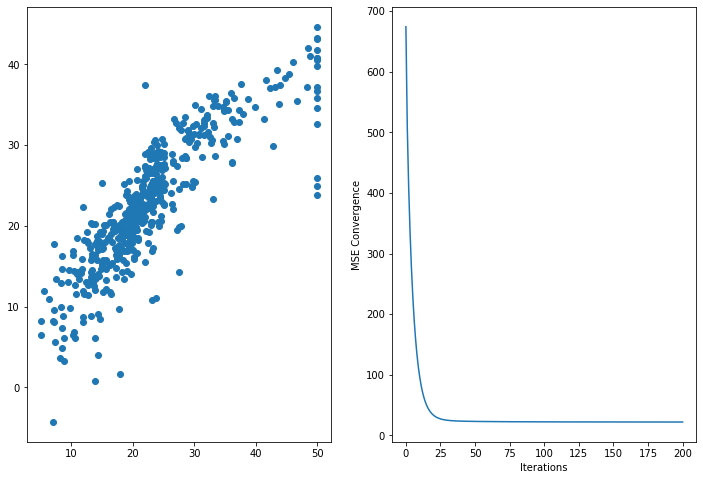

In [3]:
#Get the boston housing dataset by using the scikit-learn package. hint: load_boston
X, y = datasets.load_boston(return_X_y=True)

#What is  p ? what is  n  in the above notation?
n = X.shape[0]
p = X.shape[1]
print("Our dataset has n: {} observations with p: {} features".format(n,p))


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,8))

def scalingfeatures(X):
    scaler = StandardScaler()
    scaler.fit(X)
    return scaler.transform(X)

#Write a model OrdinaryLinearRegression which has a property  w  and 3 methods: fit, predict and score
class OrdinaryLinearRegression:
    
    def fit(self,X,y):

        #Scaling features
        X = scalingfeatures(X)
        #Padding with ones
        X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
        #fitting closed-form solution
        self.w = np.linalg.pinv(X) @ y
        return self
  
    def predict(self,X):
        ###Adding ones in front
        X = scalingfeatures(X)
        return np.concatenate((np.ones((X.shape[0],1)),X),axis=1)@self.w

    def score(self,X,y):
        return np.power((self.predict(X) - y),2).mean()

#Fit the model. What is the training MSE?
OLR = OrdinaryLinearRegression()
train = OLR.fit(X,y)
print("The training MSE for OLR is: ",train.score(X,y))

#Plot a scatter plot where on x-axis plot  𝑌  and in the y-axis  𝑌̂ 𝑂𝐿𝑆
y_pred = train.predict(X)
ax1.scatter(y,y_pred);
ax1.plot()

#Split the data to 75% train and 25% test 20 times. What is the average MSE now for train and test?
MSE_train = list()
MSE_test = list()
for i in range(20):
    #Make the random state i - so that for each split it will be different values, but the end MSE
    #Will always be the same
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=i)
    OLR = OrdinaryLinearRegression()
    train = OLR.fit(X_train,y_train)
    MSE_train.append(train.score(X_train,y_train))
    MSE_test.append(train.score(X_test,y_test))
print("The average MSE for OLR is: ",np.array(MSE_test).mean())

#Use a t-test to proove that the MSE for training is significantly smaller than for testing. What is the p-value?
t, prob = stats.ttest_rel(np.array(MSE_train), np.array(MSE_test))
print("Our p-value is: ",prob)
print("Being such a low number, we can reject the null hypothesis of identical average scores.")

#OrdinaryLinearRegressionGradientDescent
class OrdinaryLinearRegressionGradientDescent(OrdinaryLinearRegression):
    
    def __init__(self, lr, numiter):
        self.lr = lr
        self.numiter = numiter
        
    def fit(self,X,y):
        #Feature scaling
        X = scalingfeatures(X)
        #padding
        X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
        
        #implement Gradient Descent
        #initialize weights
        weights = torch.randn(X.shape[1], requires_grad=True, dtype=torch.double) 
        X = torch.from_numpy(X)
        y = torch.from_numpy(y)
        
        tolerance = 1e-3
        previous_err = np.Inf
        
        convergence = list()
        
        for i in range(self.numiter):
            pred = torch.mv(X,weights)
            diff = pred-y
            error = torch.sum(diff*diff) / diff.numel()
            convergence.append(error)
            error.backward()
                    
            with torch.no_grad():
                #Includes normalizer
                weights -= weights.grad*self.lr
            weights.grad.zero_()
                
                    
            if torch.abs(error-previous_err) < tolerance:
                self.w = weights.data.numpy()
                print("We stopped at iteration: ", i)
                ax2.plot(range(i+1),convergence)
                ax2.set_xlabel("Iterations")
                ax2.set_ylabel("MSE Convergence")
                return self
            
            previous_err = error
            
        self.w = weights.data.numpy()
        ax2.plot(range(self.numiter),convergence)
        
        ax2.set_xlabel("Iterations")
        ax2.set_ylabel("MSE Convergence")
        return self
    
    
X, y = datasets.load_boston(return_X_y=True)

OLR = OrdinaryLinearRegressionGradientDescent(lr=0.05,numiter=300)
train = OLR.fit(X,y)
print("The training MSE for ORLGD is: ",train.score(X,y))


**What is the effect of learning rate?**

The learning rate defines how large of a step one takes in the direction of the optimization. A learning rate too slow will ultimately converge but may take many many iterations, and a learning rate too large will sometimes cause our graph to jump over the minimum, and as such the gradient descent will never converge.

**How would you find number of iteration automatically?** 

You could create a tolerance (which we have done above at 1e-03), and verified if the optimization increase in any given iteration is smaller than the tolerance, and if so, to stop the looping.


**Note: Gradient Descent does not work well when features are not scaled evenly (why?!).**

It's not only G.D. but many algorithms that wont work well when the features aren't scaled evenly. This is because when we are dealing with data where the features are in different metrics, the algorithm isnt aware and just compares their numerical value, therefore giving disproportionate value to the features (Ex: If Xi - square meters of the house and Xj - number of bathrooms, with every additional bathroom in the house, the price of the house will increase dramatically, as opposed to the number of square meters). When we are traversing the exploratory unknown feature space of the data, the disunity of the data will cause us to ahead too much or too little in the wrong directions. What we all need in life is more UNITY!


In [158]:
#Bonus - Looking online I couldn't find a normal implementation of Coordiante Descent with Pytorch, so I will stick to regular
#matrix manipulation

def scalingfeatures(X):
    scaler = StandardScaler()
    scaler.fit(X)
    return scaler.transform(X)

class OrdinaryLinearRegressionCoordinateDescent(OrdinaryLinearRegression):
    
    def __init__(self,lr,num_iter):
        self.lr = lr
        self.num_iter = num_iter
    
    def lossfunction(self,X,y,w):
        m = np.size(y)    
        #Cost function in vectorized form
        y_pred = X @ w
        # J = 1/N * Sum((ẏ - y)**2)
        J = float((1./(2*m)) * (y_pred - y).T @ (y_pred - y))  
        return J
    
    def fit(self,X,y):
        X = scalingfeatures(X)
        X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
        m,n = X.shape

        np.random.seed(42)
        w = np.random.randn(n,1)
        y = y.reshape(-1,1)
        
        for iter in range(self.num_iter):
            for j in range(n):
                #Coordinate descent in vectorized form
                X_j = X[:,j].reshape(-1,1)
                y_pred = X @ w 
                gradient =  X_j.T @ (y_pred-y)
                w[j] = w[j] - self.lr * (2/n) * gradient
            loss = self.lossfunction(X,y,w)
            print(loss)
              
            
        self.w = w
        return self
    
OLRCD = OrdinaryLinearRegressionCoordinateDescent(lr=0.05,num_iter=500)
train = OLRCD.fit(X,y)
print("The training MSE for ORLGD is: ",train.score(X,y))

4900.004804417397
46578.58718891925
11394701.394167384
617890084.5422083
9172271880.374117
1323876776995.9136
201502063208457.12
5452837004221136.0
1.5507536324758355e+17
4.571895172066237e+19
2.3986861024788386e+21
2.6017544942851325e+22
8.384575680457124e+24
8.018482250500282e+26
1.4019345050726646e+28
1.1553146660502457e+30
2.1428637420277743e+32
7.455631984536903e+33
1.2962768351656269e+35
4.593299094360512e+37
2.9525080313779336e+39
3.4224832111314583e+40
7.670753792907559e+42
9.121904220027419e+44
2.0387446117315445e+46
9.534134926005863e+47
2.2618312624553676e+50
9.775348863031111e+51
1.2007245152589617e+53
4.4719622831497884e+55
3.535081182087368e+57
4.974139819037329e+58
6.769109666397115e+60
1.0111398188516526e+63
2.8656830587467166e+64
7.741933373044439e+65
2.3249943367706134e+68
1.2394259965548223e+70
1.3420531366357158e+71
4.219030180136168e+73
4.1179749262395745e+75
7.366925832400852e+76
5.756308117481081e+78
1.092540833930265e+81
3.881316470691427e+82
6.481580639668121e+

C:\Users\shaul\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in matmul


inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf


C:\Users\shaul\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in matmul
C:\Users\shaul\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in matmul


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
The training MSE for ORLGD is:  nan


## Exercise 2 - Ridge Linear Regression

Recall that ridge regression is identical to OLS but with a L2 penalty over the weights:

$L(y,\hat{y})=\frac{1}{N}\sum_{i=1}^{i=N}{(y^{(i)}-\hat{y}^{(i)})^2} + \lambda \left\Vert w \right\Vert_2$

* Show, by differentiating the above loss, that the analytical solution is $w_{Ridge}=(X^TX+\lambda I)^{-1}X^Ty$
* Change `OrdinaryLinearRegression` and `OrdinaryLinearRegressionGradientDescent` classes to work also for ridge regression (do not use the random noise analogy but use the analytical derivation). Either add a parameter, or use inheritance.
* **Bonus: Noise as a regularizer**: Show that OLS (ordinary least square), if one adds multiplicative noise to the features the **average** solution for $W$ is equivalent to Ridge regression. In other words, if $X'= X*G$ where $G$ is an uncorrelated noise with variance $\sigma$ and mean 1, then solving for $X'$ with OLS is like solving Ridge for $X$. What is the interpreation? 



In [157]:
class OrdinaryLinearRegressionPadless:
    
    def fit(self,X,y):
        self.w = np.linalg.pinv(X) @ y
        return self
  
    def predict(self,X):
        return X@self.w

    def score(self,X,y):
        return np.power((self.predict(X) - y),2).mean()


def proveL2(X,y,y_hat,w,lam):
    
    X = torch.from_numpy(X)
    y = torch.from_numpy(y)
    w = torch.from_numpy(w)
    w.requires_grad = True
    
    loss = torch.pow((torch.mv(X,w)-y),2).mean() + lam*(torch.sum(w**2))
    loss.backward()
       
    return w.grad.data.numpy()


X, y = datasets.load_boston(return_X_y=True)
X = scalingfeatures(X)
OLRPl = OrdinaryLinearRegressionPadless()
model = OLRPl.fit(X,y)
w = model.w
y_hat = model.predict(X)

#Chose an arbitrary Lambda
lam = .5

#Analytic closed-form solution
w_ridge = np.linalg.pinv(X.T@X + np.identity(X.shape[1])*lam)@X.T@y

print(np.all(np.abs(w_ridge -  proveL2(X,y,y_hat,w,lam)) < 1e-1))

True


In [162]:
 class OrdinaryLinearRegressionL2:
    
    def fit(self,X,y,lam):
        X = scalingfeatures(X)
        #Adding ones in front
        X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
        #implementing Analytic Closed-Form Solution
        self.w = np.linalg.pinv(X.T@X + np.identity(X.shape[1])*lam)@X.T@y
    
        return self
  
    def predict(self,X):
        X = scalingfeatures(X)
        return np.concatenate((np.ones((X.shape[0],1)),X),axis=1)@self.w
    
    def score(self,X,y):
        return np.power((self.predict(X) - y),2).mean()


#OrdinaryLinearRegressionGradientDescent
class OrdinaryLinearRegressionGradientDescentL2(OrdinaryLinearRegressionL2):
    
    def __init__(self, lr, numiter, lam):
        self.lr = lr
        self.numiter = numiter
        self.lam = lam
        
    def fit(self,X,y):
        X = scalingfeatures(X)
        X = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
        #implement Gradient Descent
        #initialize weights
        weights = torch.randn(X.shape[1], requires_grad=True, dtype=torch.double) 
        X = torch.from_numpy(X)
        y = torch.from_numpy(y)
        
        tolerance = 1e-03
        previous_err = np.Inf
        
        convergence = list()
        
        for i in range(self.numiter):
            pred = torch.mv(X,weights)
            diff = pred-y
            error = (torch.sum(diff*diff) / diff.numel()) + self.lam*(torch.sum(torch.pow(weights,2)))
            convergence.append(error)
            error.backward()
                        
            with torch.no_grad():
                #Includes normalizer
                weights -= (1/X.shape[0])*weights.grad*self.lr
                
            weights.grad.zero_()
                        
            if torch.abs(error-previous_err) < tolerance:
                self.w = weights.data.numpy()
                plt.plot(range(i+1),convergence)
                plt.xlabel("Iterations")
                plt.ylabel("MSE Convergence")
                return self
            
            previous_err = error
            
        self.w = weights.data.numpy()
        plt.plot(range(self.numiter),convergence)
        
        plt.xlabel("Iterations")
        plt.ylabel("MSE Convergence")
        return self
    
    #Predict and Score inherited

The training MSE for OLRL2 is:  21.894832406225092
The training MSE for ORLGDL2 is:  23.62303118739404


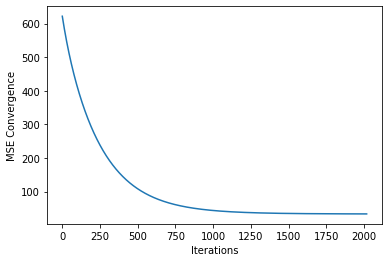

In [168]:
OLR = OrdinaryLinearRegressionL2()
train = OLR.fit(X,y,lam=0.02)
print("The training MSE for OLRL2 is: ",train.score(X,y))

OLR = OrdinaryLinearRegressionGradientDescentL2(lr=.5,numiter=5000,lam=.02)
train = OLR.fit(X,y)
print("The training MSE for ORLGDL2 is: ",train.score(X,y))

An interesting observation is that as Lambda gets higher, it takes more iterations for GD to approximate our closed-form solution, and if lambda gets too high, its error alone will be main reason for the MSE (although the weights will be close to the perfect weights).
As such, it seems logical that when trying to estimate lambda we would also have to use parameter approximation methods - such as the elbow curve, etc.

## Exercise 3 - Lasso Linear Regression

As we've seen in class, Lasso Regression is a regularization technique with $L_1$ penalty on weights. This techniques creates sparse weights (some weights become effectively zero). Programming a Lasso solver is a challange and is left as an optional exercise below.
This exercise will focus on the analysis of the different regularization techniques over a toy problem using the scikit-learn implementation.

### Data generation: 1-D Polynomal Regression
```
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 30
degrees = [1, 4, 15]
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

```

* Use the preprocessing transformer `sklearn.preprocessing.PolynomialFeatures` in order to create a feature space. Note, you can use `sklearn.pipeline.Pipeline` in order to create an effective model which does the preprocessing (not essential).
* Use `sklearn.model_selection.cross_val_score` to evaluate each of the linear model provided by Scikit-learn (`from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV`) and compare the performance over the different `degrees`. To do so, create a 3x3 plot where each row correspond to one model and each column to one degree. Each plot should plot the train data as well as the true model and the fitted one (use 100 points in the range [0,1]) and the CV (cross validation) MSE. What is the take home message? (Note: RidgeCV and LassoCV do an internal cross-validation to determin the regularization parameter.)
* Weights spectrum: change the `alpha` parameter gradually (on a logartithmic scale) and observe how the coefficients change for `degrees=5` over alpha for Ridge and Lasso. What is the take home message?

In [127]:
#sklearn.preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=True, order='C')
from sklearn.preprocessing import PolynomialFeatures as PolynomialFeatures
#sklearn.pipeline.Pipeline(steps, memory=None, verbose=False)
from sklearn.pipeline import Pipeline as Pipeline
from sklearn.model_selection import cross_val_score as cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso

In [172]:
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 30
degrees = [1, 4, 15]
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

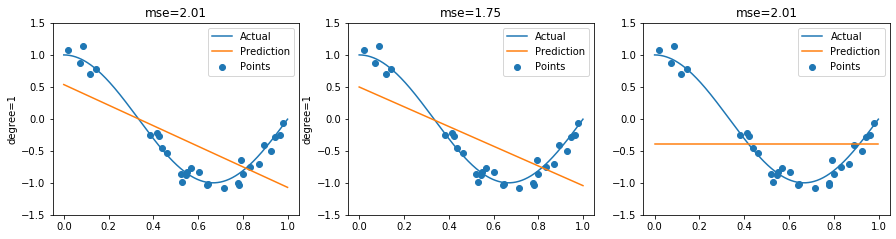

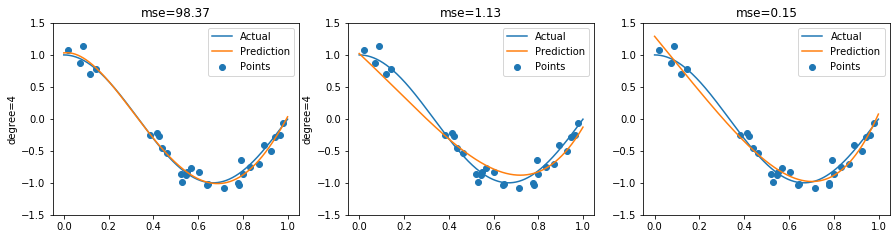

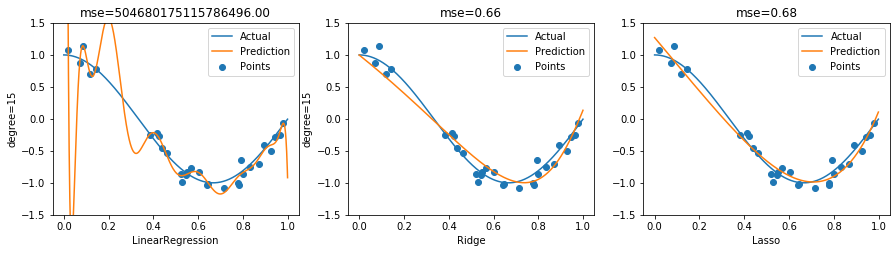

In [174]:
np.random.seed(0)
mse_summary = {}
degrees = [1,4,15]
n_degrees = len(degrees)

for i,degree in enumerate(degrees):  
    
    X_poly = X.reshape(-1,1)
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X_poly)
    
    X_test = np.arange(0,1,0.001).reshape(-1,1)
    X_test_poly = poly.fit_transform(X_test)
    
    lin = LinearRegression()
    mse = -1*cross_val_score(lin,X_poly,y,cv=5,scoring='neg_mean_squared_error').mean()
    lin.fit(X_poly,y)
    mse_summary[('LinearRegression',degree)] = mse
    plt.figure(figsize=(15,12))
    ax = plt.subplot(3,3,3*i+1)
    plt.scatter(X,y)
    plt.plot(X_test,true_fun(X_test))
    plt.plot(X_test,lin.predict(X_test_poly))
    ax.set_title("mse={:.2f}".format(mse))
    ax.set_ylabel("degree="+str(degree))
    ax.set_ylim((-1.5, 1.5))
    ax.legend(["Actual","Prediction","Points"])
    if i+1==n_degrees:
        ax.set_xlabel('LinearRegression')

    ridge = RidgeCV()
    mse = -1*cross_val_score(ridge,X_poly,y,cv=5,scoring='neg_mean_squared_error').mean()
    ridge.fit(X_poly,y)
    mse_summary[('Ridge',degree)] = mse
    ax = plt.subplot(3,3,3*i+2)
    plt.scatter(X,y)
    plt.plot(X_test,true_fun(X_test))
    plt.plot(X_test,ridge.predict(X_test_poly))
    ax.set_title("mse={:.2f}".format(mse))
    ax.set_ylabel("degree="+str(degree))
    ax.set_ylim((-1.5, 1.5))
    ax.legend(["Actual","Prediction","Points"])
    if i+1==n_degrees:
        ax.set_xlabel('Ridge')
    
    lasso = LassoCV(max_iter=30000,tol=1e-03,cv=5)
    mse =-1*cross_val_score(lasso,X_poly,y,cv=5,scoring='neg_mean_squared_error').mean()
    lasso.fit(X_poly,y)
    mse_summary[('Lasso',degree)] = mse
    ax =plt.subplot(3,3,3*i+3)
    plt.scatter(X,y)
    plt.plot(X_test,true_fun(X_test))  
    plt.plot(X_test,lasso.predict(X_test_poly))
    ax.set_title("mse={:.2f}".format(mse))
    ax.set_ylim((-1.5, 1.5))
    ax.legend(["Actual","Prediction","Points"])
    if i+1==n_degrees:
        ax.set_xlabel('Lasso')
            
    

**What is the take-home message?**

As we increase the number of degrees, without regularization, our linear regression model will highly overfit the data, so much so that with a large enough dimensionality, the MSE will be massive.

As we can see, both Lasso and Ridge did a pretty wholesome job of getting the prediction to be pretty accurate with the actual model.

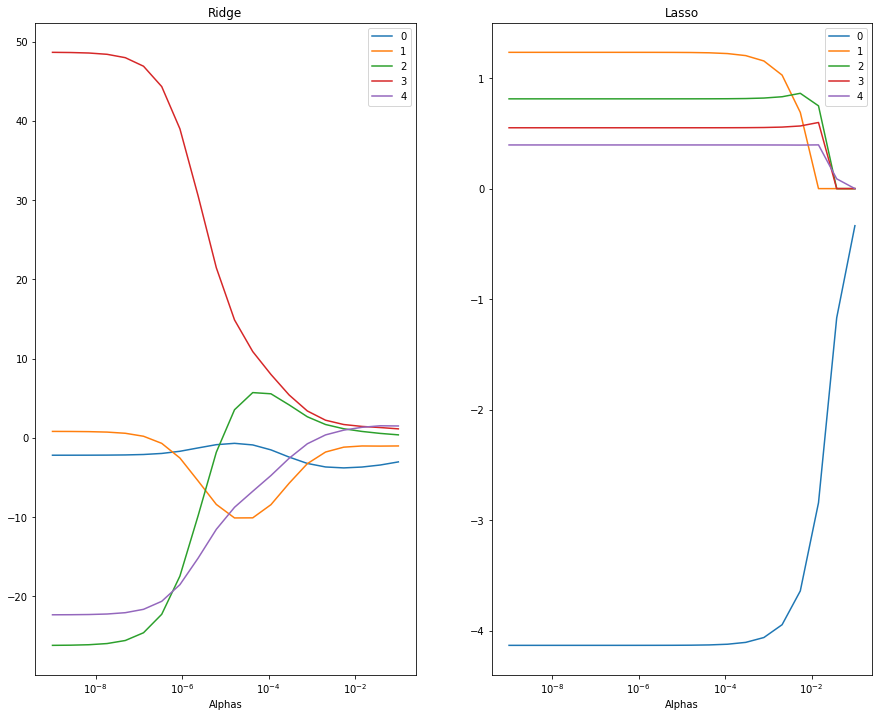

In [184]:
plt.figure(figsize=(15,12))

degree = 5

X_poly = X.reshape(-1,1)
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X_poly)

alphas = np.logspace(-9,-1,20)

ax = plt.subplot(1,2,1)
ax.set_title("Ridge")

coefs = np.zeros(degree+1)

for alpha in alphas:
    reg = Ridge(alpha=alpha)
    reg.fit(X_poly,y)
    coefs = np.vstack((coefs,reg.coef_))
    
coefs = coefs[1:,1:]
ax.set_xscale('log')

for i in range(degree):
    ax.plot(alphas,coefs[:,i])

ax.legend(range(degree))
ax.set_xlabel('Alphas')

ax = plt.subplot(1,2,2)
ax.set_title("Lasso")

coefs =np.array([0]*(degree+1))
for alpha in alphas:
    reg = Lasso(alpha=alpha,max_iter=30000,tol=0.1)
    reg.fit(X_poly,y)
    coefs = np.vstack((coefs,reg.coef_))

coefs = coefs[1:,1:]

ax.set_xscale('log')
for i in range(degree):
    ax.plot(alphas,coefs[:,i])
ax.legend(range(degree))
ax.set_xlabel('Alphas')

plt.show();

As we can see, with Lasso, as alpha increases, they all turn to zero, because as the penalty increases for existing, the cheapest option is to just have the parameters equal to zero.

With Ridge, as alpha increases, there is also the added penalty, but Ridge goal isn't to remove the parameters, just to minimize them, so we see them all approaching zero, but never actually getting to zero.